# Logistic Rrgression - Multiclass

## Problem statements :  Predicting the Activity by recognizing the movements pattern. Activities are classified as
- Bending
- Cycling
- lying
- sitting
- standing
- walking

https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+%28AReM%29


## Import Required Data

In [679]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import os
import logging
import warnings
import pickle
warnings.simplefilter("ignore")
logging.basicConfig(filename='AReM.log',level = logging.INFO,force = True)
logging.info("Activities Recognition System")

## Class Data collection

In [680]:
class datacollection:
    
    def __init__(self):
        pass
    
    def getdata(self,datasource):
        """ This method, collects the data from different folders and merges and returns final data frame for further process"""
        totalFiles = 0
        totalDir = 0
        path = datasource
        temp = pd.DataFrame()
        try:
            for base, dirs, files in os.walk(datasource):
                #print('Searching in : ',base)
                for directories in dirs:
                   # print("searching in ", directories)
                    folderpath = path+"\\"+directories
                    totalFiles = 0
                    for _, _, files in os.walk(folderpath):
                        for Files in files:
                            filepath = folderpath+"\\"+Files              
                            df = pd.read_csv(filepath,skiprows=4,error_bad_lines=False,)
                            df['label'] = directories
                            temp = temp.append(df,ignore_index=True)
                            df = temp.drop(columns=['# Columns: time'],axis = 1)
            logging.info("Data collection completed")
            return df 
        except Exception as e:
            logging.exception(str(e))


## Class EDA

In [681]:
class EDA():
    
    def __init__(self):
        pass
    
     ## 1. Load the data set
    def loaddata(self,filename):
        
        """ Load the data """
        try:
            df = pd.read_csv(filename)
            logging.info("Dataset loaded!")
            return df
        except Exception as e:
            logging.exception(str(e)) 
            
            
    #  panda profiling
    def profiling(self,df):
        
        """ Performs EDA on dataset and saves the profiling file. """
        try:
            pf = pp.ProfileReport(df)
            pd_f = pf.to_widgets()
            pf.to_file("AReM_Profiling.html")
            logging.info("Profiling completed")
            return df
        except Exception as e:
            logging.exception(str(e))
            
    def eda(self,filename):
        
        """ performs initial EDA"""
        df = self.loaddata(filename)
        df = self.profiling(df)
        return df

## class datapreprocessing

In [682]:
class Datapreprocessing():
    
    def __init__(self):
        pass
    
    def clean_column_names(self,df):
        """ Removes special charectors and space
        form columns names"""
        try:
            columns = df.columns
            colupdated = []
            for col in columns:
                removespecialchars = col.translate({ord(c): "" for c in "!@#$%^&*()[]{};:,. /<>?\|`~-=_+'"})
                colupdated.append(removespecialchars)
            df.columns = colupdated
            logging.info("Column header updated")
            return df
        except Exception as e:
            logging.exception(str(e))  
    

    def remove_outlier_IQR(self,df, q1=0.25, q3=0.75):
        """ Removes outliers with Q1 = 0.25, Q3 = 0.75"""

        try:        
            Q1 = df.quantile(q1)
            Q3 = df.quantile(q3)
            IQR = Q3 - Q1
            df_final = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))]
            logging.info("Outliers removed")
            return df_final
        except Exception as e:
            logging.exception(str(e))
    
    def drop_duplicate(self,df, keep = 'first'):
        """ Drops duplicate rows
        keep = first - keeping the first occurrence
        keep = 'fast - keeping last occurrence
        keep = False - keeps nothing. """
        try:
            df = df.drop_duplicates(subset=None, keep= keep, inplace=False)
            return df
        except Exception as e:
            logging.exception(str(e))

    def drop_missing_value(self,df, axis=0):
        """Drops missing values rows or columns
         df - DataFrame
         axis = 1 - columns
         axis = 0 - rows """

        try:
            reduced_df = df.dropna(axis=axis)
            logging.info("Missing values dropped")
            return reduced_df
        except Exception as e:
            logging.exception(str(e))


    def impute_missing_value(self,df):
        """make new columns indicating what will be imputed"""

        try:
            cols_with_missing = (col for col in df.columns
                                 if df[col].isna().any())
            for col in cols_with_missing:
                df[col + '_was_missing'] = df[col].isnull()
            columns = df.columns
            # Imputation
            my_imputer = SimpleImputer()
            df = pd.DataFrame(my_imputer.fit_transform(df), columns=columns)
            logging.info("Missing values imputed")
            return df
        except Exception as e:
            logging.exception(str(e))


    def dataprocess(self,df):
        """ removing diplicate rows"""
        print("Duplicate rows deleted")
        df = self.drop_duplicate(df)        
        return df

    

    

## Class Visualization

In [683]:
class VisualizeData():
    
    def __init__(self):
        pass
    
    def bivariateanalysis(df):
        pass
        
        pass
    def multivariateanalysis(self,df):
        """ Displays multivariate analysis"""
        sns.pairplot(df,height=2,diag_kind='kde')
        #return df
    def distribution_plot(self,df):
        plt.figure(figsize=(20,25), facecolor='white')
        plotnumber = 1

        for column in df:
            if plotnumber<=6 :     # as there are 9 columns in the data
                ax = plt.subplot(3,3,plotnumber)
                sns.distplot(df[column])
                plt.xlabel(column,fontsize=20)
                #plt.ylabel('Salary',fontsize=20)
            plotnumber+=1
        plt.show()
        

In [744]:
class AReMModelTrain():
    models_ = []
    accuracy_dict = {"Model":[],"Accuracy" :[]}
    
    def __init__(self):
        pass
    
    def find_multicolinearity(self,X_scaled):
        """ Finding multicolinearity"""
        try:
           # print(X_scaled)
            vif = pd.DataFrame()
            vif["vif"] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
            vif["Features"] = X.columns
            logging.info("Checking multicollinearity")   
            return vif
        except Exception as e:
            logging.exception(str(e))
    
    def sepatate_X_y(self,df):
        """ seperate dependent and indepented feature"""
        try:
            X = df.drop('label',axis=1)
            y = df['label']
            ## Splitting data
            logging.info("Data sepeation completed")
            return X,y
        except Exception as e:
            logging.exception(str(e))   
            
    def splitdata(self,X,y):
        """ split data into train and test"""
        try:
            
            ## Splitting data
            logging.info("Data Splitting completed")
            return train_test_split(X,y,test_size=0.2,random_state=42)   
        except Exception as e:
            logging.exception(str(e)) 
            
    def trainmodel(self,x_train,y_train, x_test,y_test,multi_class,lstsolver):
        """ trains different model, saves model, and returns models"""
        models = []
        lstsolver=['newton-cg','sag','saga','lbfgs']
        try:
            for sol in lstsolver:
                lr = LogisticRegression(multi_class=multi_class,solver=sol)        
                lr.fit(x_train,y_train)
                name = sol+multi_class
                models.append((name,lr))
                logging.info("Data training with  solver")
                logging.info(sol) 
                self.models_ = models
            self.savemodel(models)
            return models
        except Exception as e:
            logging.exception(str(e))
            
    def savemodel(self,models):
        """ saves all models"""
        try:
            with open("AReM_models.pckl", "ab") as f:
                for model in models:
                    pickle.dump(model, f)
        except Exception as e:
            logging.exception(str(e))
        
    def getaccscore(self,x_test,y_test,models):
        """ resutns all scores in a dataframe"""
        acc_lst = []
        recall_lst = []
        precision_lst = []
        f1_score_lst = []
        auc_list = []
        model_name_lst = []
        try:
            for name, model in models:
                y_pred = model.predict(x_test)                
                conf_mat = confusion_matrix(y_test,y_pred)
                true_positive = conf_mat[0][0]
                false_positive = conf_mat[0][1]
                false_negative = conf_mat[1][0]
                true_negative = conf_mat[1][1]
                accuracy = (true_positive + true_negative) / (true_positive +false_positive + false_negative + true_negative)
                precision = true_positive/(true_positive+false_positive)
                recall = true_positive/(true_positive+false_negative)
                f1_score = 2*(recall * precision) / (recall + precision)
                auc = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr')
                model_name_lst.append(name)
                acc_lst.append(accuracy)
                recall_lst.append(recall)
                precision_lst.append(precision)
                f1_score_lst.append(f1_score)
                auc_list.append(auc)       
                
            df_score = pd.DataFrame({"Model": model_name_lst, " Accuracy" :acc_lst, "Precision" : precision_lst,"Recall":recall_lst,
                                    "F1_Score":f1_score_lst,"Auc" : auc_list})
            return df_score
        except Exception as e:
            logging.exception(str(e))
                
                




In [685]:
class Datatransform():
    def __init__(self):
        pass
    
    def standardscaler(self,X):
        """performs standardization"""
        try:
            scalar = StandardScaler()
            X_scaled = scalar.fit_transform(X)
            logging.info("Data transformation - StandardScaler")
            return X_scaled
        except Exception as e:
            logging.exception(str(e))
            
    def labelEncoder(self,df):
        """ performs label concoding"""
        try:
            #print(df)
            
            encoder = LabelEncoder()
            df["label"] = encoder.fit_transform(df['label'])           
            logging.info("Label encoded")
            return df
        except Exception as e:
            logging.exception(str(e))

## Data Collection from different folders

In [686]:
data = datacollection()
df = data.getdata(datasource)


b'Skipping line 485: expected 7 fields, saw 8\n'
b'Skipping line 485: expected 7 fields, saw 8\n'


## Saving the collected  data

In [687]:
df.to_csv("AReM_cleaned.csv",index=False)
ar_data = pd.read_csv("AReM_cleaned.csv")
ar_data

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
0,39.25,0.43,22.75,0.43,33.75,1.30,bending1
1,39.25,0.43,23.00,0.00,33.00,0.00,bending1
2,39.25,0.43,23.25,0.43,33.00,0.00,bending1
3,39.50,0.50,23.00,0.71,33.00,0.00,bending1
4,39.50,0.50,24.00,0.00,33.00,0.00,bending1
...,...,...,...,...,...,...,...
42232,31.50,1.66,12.50,3.20,14.25,4.44,walking
42233,27.33,1.25,11.33,0.94,20.00,4.00,walking
42234,37.80,7.68,14.20,2.48,17.25,0.83,walking
42235,33.75,1.30,15.75,5.21,16.50,2.69,walking


In [688]:
ar_data.label.unique()

array(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing',
       'walking'], dtype=object)

In [689]:
ar_data.isnull().sum()

avg_rss12    480
var_rss12    480
avg_rss13    480
var_rss13    480
avg_rss23    480
var_rss23    480
label          0
dtype: int64

In [690]:
EDA().profiling(ar_data)

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
0,39.25,0.43,22.75,0.43,33.75,1.30,bending1
1,39.25,0.43,23.00,0.00,33.00,0.00,bending1
2,39.25,0.43,23.25,0.43,33.00,0.00,bending1
3,39.50,0.50,23.00,0.71,33.00,0.00,bending1
4,39.50,0.50,24.00,0.00,33.00,0.00,bending1
...,...,...,...,...,...,...,...
42232,31.50,1.66,12.50,3.20,14.25,4.44,walking
42233,27.33,1.25,11.33,0.94,20.00,4.00,walking
42234,37.80,7.68,14.20,2.48,17.25,0.83,walking
42235,33.75,1.30,15.75,5.21,16.50,2.69,walking


## Removing duplicate rows

In [691]:
df_duplicate_removed = Datapreprocessing().drop_duplicate(ar_data)
df_duplicate_removed

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
0,39.25,0.43,22.75,0.43,33.75,1.30,bending1
1,39.25,0.43,23.00,0.00,33.00,0.00,bending1
2,39.25,0.43,23.25,0.43,33.00,0.00,bending1
3,39.50,0.50,23.00,0.71,33.00,0.00,bending1
4,39.50,0.50,24.00,0.00,33.00,0.00,bending1
...,...,...,...,...,...,...,...
42232,31.50,1.66,12.50,3.20,14.25,4.44,walking
42233,27.33,1.25,11.33,0.94,20.00,4.00,walking
42234,37.80,7.68,14.20,2.48,17.25,0.83,walking
42235,33.75,1.30,15.75,5.21,16.50,2.69,walking


## Dropping missing values

In [692]:
df_duplicate_removed.isnull().sum()

avg_rss12    1
var_rss12    1
avg_rss13    1
var_rss13    1
avg_rss23    1
var_rss23    1
label        0
dtype: int64

In [693]:

df_dropped_missing = Datapreprocessing().drop_missing_value(df_duplicate_removed)
df_dropped_missing

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
0,39.25,0.43,22.75,0.43,33.75,1.30,bending1
1,39.25,0.43,23.00,0.00,33.00,0.00,bending1
2,39.25,0.43,23.25,0.43,33.00,0.00,bending1
3,39.50,0.50,23.00,0.71,33.00,0.00,bending1
4,39.50,0.50,24.00,0.00,33.00,0.00,bending1
...,...,...,...,...,...,...,...
42232,31.50,1.66,12.50,3.20,14.25,4.44,walking
42233,27.33,1.25,11.33,0.94,20.00,4.00,walking
42234,37.80,7.68,14.20,2.48,17.25,0.83,walking
42235,33.75,1.30,15.75,5.21,16.50,2.69,walking


In [694]:
df_dropped_missing.isna().sum()

avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
label        0
dtype: int64

## Data Visualization

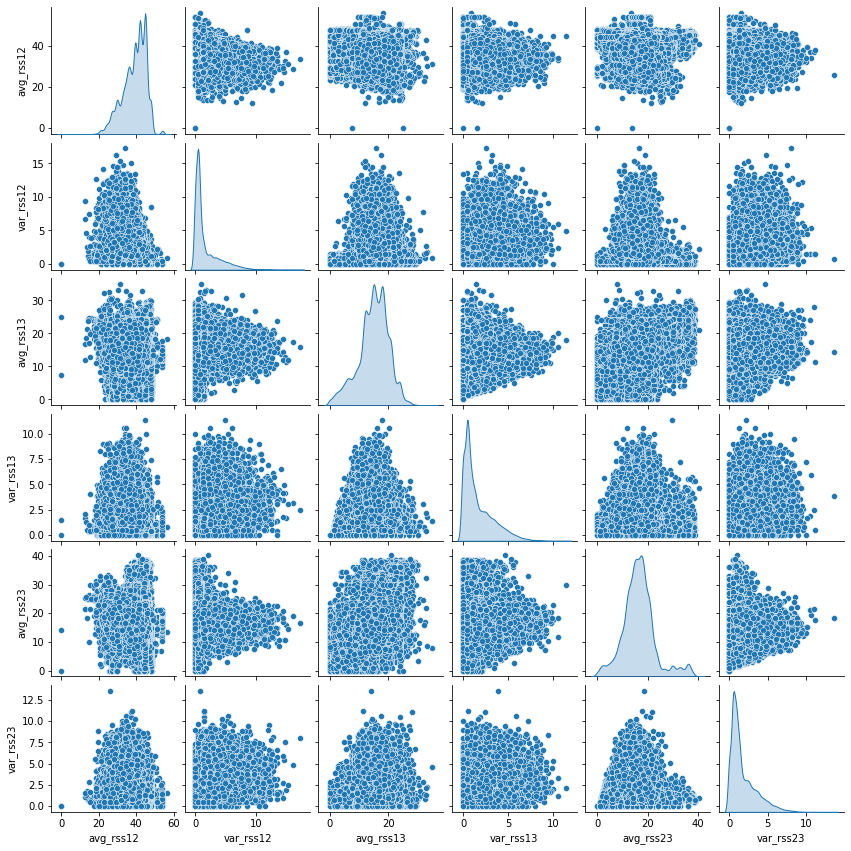

In [695]:
VisualizeData().multivariateanalysis(df_dropped_missing)

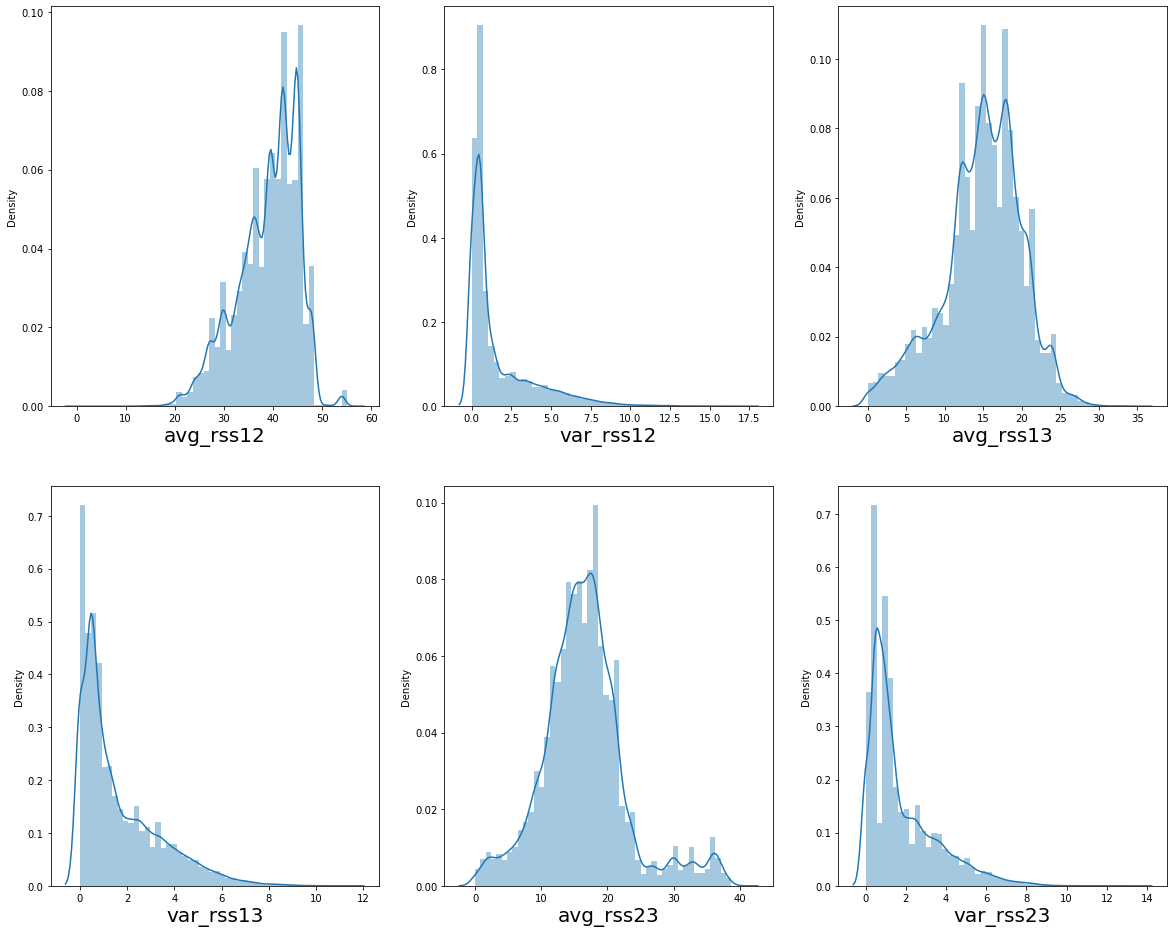

In [696]:
VisualizeData().distribution_plot(df_dropped_missing)

## Lable Encoding

In [697]:
df_labeled = Datatransform().labelEncoder(df_dropped_missing)

In [698]:
df_labeled

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
0,39.25,0.43,22.75,0.43,33.75,1.30,0
1,39.25,0.43,23.00,0.00,33.00,0.00,0
2,39.25,0.43,23.25,0.43,33.00,0.00,0
3,39.50,0.50,23.00,0.71,33.00,0.00,0
4,39.50,0.50,24.00,0.00,33.00,0.00,0
...,...,...,...,...,...,...,...
42232,31.50,1.66,12.50,3.20,14.25,4.44,6
42233,27.33,1.25,11.33,0.94,20.00,4.00,6
42234,37.80,7.68,14.20,2.48,17.25,0.83,6
42235,33.75,1.30,15.75,5.21,16.50,2.69,6


## Saving cleaned dataset

In [699]:
df_labeled.to_csv("AreM_final.csv",index=False)

## Seperate independent and dependent features

In [700]:
X,y = AReMModelTrain().sepatate_X_y(df_labeled)

In [701]:
X

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,39.25,0.43,22.75,0.43,33.75,1.30
1,39.25,0.43,23.00,0.00,33.00,0.00
2,39.25,0.43,23.25,0.43,33.00,0.00
3,39.50,0.50,23.00,0.71,33.00,0.00
4,39.50,0.50,24.00,0.00,33.00,0.00
...,...,...,...,...,...,...
42232,31.50,1.66,12.50,3.20,14.25,4.44
42233,27.33,1.25,11.33,0.94,20.00,4.00
42234,37.80,7.68,14.20,2.48,17.25,0.83
42235,33.75,1.30,15.75,5.21,16.50,2.69


In [702]:
y

0        0
1        0
2        0
3        0
4        0
        ..
42232    6
42233    6
42234    6
42235    6
42236    6
Name: label, Length: 36614, dtype: int32

## Stadardization

In [703]:
X_scaled = Datatransform().standardscaler(X)

In [704]:
X_scaled

array([[ 5.16610166e-02, -5.51403332e-01,  1.54648777e+00,
        -7.15444459e-01,  2.66975319e+00, -2.65865592e-01],
       [ 5.16610166e-02, -5.51403332e-01,  1.59556009e+00,
        -9.71863297e-01,  2.55365163e+00, -1.04063384e+00],
       [ 5.16610166e-02, -5.51403332e-01,  1.64463241e+00,
        -7.15444459e-01,  2.55365163e+00, -1.04063384e+00],
       ...,
       [-1.85625408e-01,  2.84650328e+00, -1.31785626e-01,
         5.07017446e-01,  1.15518824e-01, -5.45974111e-01],
       [-8.48390940e-01, -1.43654539e-01,  1.72462767e-01,
         2.13497891e+00, -5.82738054e-04,  5.62540455e-01],
       [-1.02512842e+00,  6.95276887e-01,  7.45627481e-01,
        -6.91591543e-01, -3.87587946e-01,  8.42648974e-01]])

## Finding Multicollinearity

In [705]:
vif = AReMModelTrain().find_multicolinearity(X_scaled)
vif

,vif,Features
0,1.260627,avg_rss12
1,1.725621,var_rss12
2,1.255595,avg_rss13
3,1.622338,var_rss13
4,1.248242,avg_rss23
5,1.667837,var_rss23


## Split train an test set

In [706]:
x_train,x_test,y_train,y_test = AReMModelTrain().splitdata(X_scaled,y)

In [707]:
x_train

array([[ 0.91080152, -0.34518555,  0.0252458 ,  0.48912776,  0.38642247,
        -0.06919365],
       [-0.07107334, -0.22801636, -0.6617667 , -0.67370186,  0.46382351,
        -0.74264605],
       [-0.43927641,  0.26409425,  0.7122583 ,  2.22442734,  0.85082872,
         0.41950632],
       ...,
       [-0.68474513,  0.36251638,  0.0252458 ,  0.54876005, -0.46498899,
         0.56254045],
       [ 0.70624426, -0.36393262,  1.88999402, -0.67370186,  3.01805788,
        -1.04063384],
       [ 0.09257247, -0.51859596, -1.54506848, -0.24434938, -0.15538482,
        -0.52213509]])

In [708]:
y_train

32732    5
28711    5
7362     2
15583    3
30030    5
        ..
21668    4
7091     2
12599    2
970      0
20107    3
Name: label, Length: 29291, dtype: int32

## Build model with different solver type and multi_class ='ovr'

In [745]:
models  = AReMModelTrain().trainmodel(x_train,y_train,x_test,y_test,'ovr',['newton-cg', 'sag', 'saga','lbfgs'])

In [746]:
models

[('newton-cgovr', LogisticRegression(multi_class='ovr', solver='newton-cg')),
 ('sagovr', LogisticRegression(multi_class='ovr', solver='sag')),
 ('sagaovr', LogisticRegression(multi_class='ovr', solver='saga')),
 ('lbfgsovr', LogisticRegression(multi_class='ovr'))]

## Score of each model Train

In [747]:
acc = AReMModelTrain().getaccscore(x_train,y_train,models)

In [748]:
acc

,Model,Accuracy,Precision,Recall,F1_Score,Auc
0,newton-cgovr,0.957658,0.998533,0.933272,0.9648,0.922071
1,sagovr,0.957658,0.998533,0.933272,0.9648,0.922071
2,sagaovr,0.957646,0.998533,0.933272,0.9648,0.922071
3,lbfgsovr,0.957658,0.998533,0.933272,0.9648,0.922071


## Score of each model on Test data

In [749]:
acc_ovr = AReMModelTrain().getaccscore(x_test,y_test,models)

In [750]:
acc_ovr

,Model,Accuracy,Precision,Recall,F1_Score,Auc
0,newton-cgovr,0.95419,0.996117,0.929348,0.961575,0.924941
1,sagovr,0.95419,0.996117,0.929348,0.961575,0.924942
2,sagaovr,0.95419,0.996117,0.929348,0.961575,0.924942
3,lbfgsovr,0.95419,0.996117,0.929348,0.961575,0.924942


In [751]:
acc_ovr['multiclass'] = 'ovr'

In [752]:
acc_ovr

,Model,Accuracy,Precision,Recall,F1_Score,Auc,multiclass
0,newton-cgovr,0.95419,0.996117,0.929348,0.961575,0.924941,ovr
1,sagovr,0.95419,0.996117,0.929348,0.961575,0.924942,ovr
2,sagaovr,0.95419,0.996117,0.929348,0.961575,0.924942,ovr
3,lbfgsovr,0.95419,0.996117,0.929348,0.961575,0.924942,ovr


## Build models with dofferent solvers and multi_class 'multinomial'

In [753]:
models  = AReMModelTrain().trainmodel(x_train,y_train,x_test,y_test,'multinomial',['newton-cg', 'sag', 'saga','lbfgs'])

In [754]:
models

[('newton-cgmultinomial',
  LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('sagmultinomial',
  LogisticRegression(multi_class='multinomial', solver='sag')),
 ('sagamultinomial',
  LogisticRegression(multi_class='multinomial', solver='saga')),
 ('lbfgsmultinomial', LogisticRegression(multi_class='multinomial'))]

## Score of models with train data

In [755]:
acc = AReMModelTrain().getaccscore(x_train,y_train,models)

In [756]:
acc

,Model,Accuracy,Precision,Recall,F1_Score,Auc
0,newton-cgmultinomial,0.954905,0.994021,0.933552,0.962838,0.928976
1,sagmultinomial,0.954905,0.994021,0.933552,0.962838,0.928976
2,sagamultinomial,0.954905,0.994021,0.933552,0.962838,0.928976
3,lbfgsmultinomial,0.954905,0.994021,0.933552,0.962838,0.928976


## Score of models on test data

In [757]:
acc_multinomial = AReMModelTrain().getaccscore(x_test,y_test,models)

In [758]:
acc_multinomial

,Model,Accuracy,Precision,Recall,F1_Score,Auc
0,newton-cgmultinomial,0.957126,0.994,0.93597,0.964113,0.930829
1,sagmultinomial,0.957126,0.994,0.93597,0.964113,0.930828
2,sagamultinomial,0.957126,0.994,0.93597,0.964113,0.930828
3,lbfgsmultinomial,0.957126,0.994,0.93597,0.964113,0.930829


In [759]:
acc_multinomial['multiclass'] = 'multinomial'

In [760]:
acc_multinomial

,Model,Accuracy,Precision,Recall,F1_Score,Auc,multiclass
0,newton-cgmultinomial,0.957126,0.994,0.93597,0.964113,0.930829,multinomial
1,sagmultinomial,0.957126,0.994,0.93597,0.964113,0.930828,multinomial
2,sagamultinomial,0.957126,0.994,0.93597,0.964113,0.930828,multinomial
3,lbfgsmultinomial,0.957126,0.994,0.93597,0.964113,0.930829,multinomial


## Final Score

In [761]:
score_final = acc_ovr.append(acc_multinomial,ignore_index=True)

In [762]:
score_final

,Model,Accuracy,Precision,Recall,F1_Score,Auc,multiclass
0,newton-cgovr,0.954190,0.996117,0.929348,0.961575,0.924941,ovr
1,sagovr,0.954190,0.996117,0.929348,0.961575,0.924942,ovr
2,sagaovr,0.954190,0.996117,0.929348,0.961575,0.924942,ovr
3,lbfgsovr,0.954190,0.996117,0.929348,0.961575,0.924942,ovr
4,newton-cgmultinomial,0.957126,0.994000,0.935970,0.964113,0.930829,multinomial
5,sagmultinomial,0.957126,0.994000,0.935970,0.964113,0.930828,multinomial
6,sagamultinomial,0.957126,0.994000,0.935970,0.964113,0.930828,multinomial
7,lbfgsmultinomial,0.957126,0.994000,0.935970,0.964113,0.930829,multinomial


## The best Model

In [763]:
score_final.iloc[np.where(score_final['Auc'].max())]

,Model,Accuracy,Precision,Recall,F1_Score,Auc,multiclass
0,newton-cgovr,0.95419,0.996117,0.929348,0.961575,0.924941,ovr


In [764]:
x_test

array([[ 0.21530683, -0.36393262, -0.46547741, -0.67370186, -1.66470513,
        -0.39102046],
       [-0.43927641, -0.55140333,  1.10483687,  0.84095826,  0.30902143,
         1.77237087],
       [ 1.11535878, -0.55140333,  1.1539092 , -0.71544446, -0.42628847,
        -0.54597411],
       ...,
       [ 1.23809314, -0.51859596,  0.87517841, -0.69159154,  0.02573362,
        -0.76052532],
       [ 1.48356186, -0.75293434, -1.15248991, -0.24434938, -1.16159836,
        -0.61749118],
       [ 0.5835099 , -0.34518555, -1.02097609, -0.41131979, -0.27148638,
        -0.54597411]])

In [765]:
y_test

14989    3
8242     2
33622    5
36691    6
8607     2
        ..
11907    2
11467    2
24257    4
34017    5
30017    5
Name: label, Length: 7323, dtype: int32

## Prediction

In [766]:
models = []
with open("AReM_models.pckl", "rb") as f:
    while True:
        try:
            models.append(pickle.load(f))
        except EOFError:
            break
models

[('newton-cgovr', LogisticRegression(multi_class='ovr', solver='newton-cg')),
 ('sagovr', LogisticRegression(multi_class='ovr', solver='sag')),
 ('sagaovr', LogisticRegression(multi_class='ovr', solver='saga')),
 ('lbfgsovr', LogisticRegression(multi_class='ovr')),
 ('newton-cgmultinomial',
  LogisticRegression(multi_class='multinomial', solver='newton-cg')),
 ('sagmultinomial',
  LogisticRegression(multi_class='multinomial', solver='sag')),
 ('sagamultinomial',
  LogisticRegression(multi_class='multinomial', solver='saga')),
 ('lbfgsmultinomial', LogisticRegression(multi_class='multinomial'))]

In [767]:
predLst = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
for name, model in models:    
    if name == 'newton-cgovr':        
        pred = model.predict([[ 0.21530683, -0.36393262, -0.46547741, -0.67370186, -1.66470513,-0.39102046]])
        print("Predicting - ", predLst[int(pred)])
        
    

Predicting -  standing


In [768]:
logging.shutdown()